In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import bilby
import scrinet
from scrinet.analysis import matchedfilter_batch as mf
from scrinet.analysis import frequencyseries_batch as fs
from scrinet.analysis import utils as ut

In [4]:
bilby.utils.setup_logger()

In [5]:
time_duration = 1.         # set the signal duration (seconds)
sampling_frequency = 4096. # set the data sampling frequency (Hz)

injection_parameters = dict(
mass_1=36.,                          # detector frame (redshifted) primary mass (solar masses)
mass_2=29.,                          # detector frame (redshifted) secondary mass (solar masses)
a_1=0,                               # primary dimensionless spin magnitude
a_2=0,                               # secondary dimensionless spin magnitude
tilt_1=0,                            # polar angle between primary spin and the orbital angular momentum (radians)
tilt_2=0,                            # polar angle between secondary spin and the orbital angular momentum 
phi_12=0,                            # azimuthal angle between primary and secondary spin (radians)
phi_jl=0,                            # azimuthal angle between total angular momentum and orbital angular momentum (radians)
luminosity_distance=100.,            # luminosity distance to source (Mpc)
theta_jn=0.4,                        # angle between the total angular momentum (both spin and orbital) and the line of sight
phase=1.3,                           # phase (radians)
waveform_approximant='IMRPhenomPv2', # waveform approximant name
reference_frequency=50.,             # gravitational waveform reference frequency (Hz)
ra=1.375,                            # source right ascension (radians)
dec=-1.2108,                         # source declination (radians)
geocent_time=1126259642.413,         # reference time at geocentre (time of coalescence or peak amplitude) (GPS seconds)
psi=2.659                            # gravitational wave polarisation angle
)

In [6]:
# initialise the waveform generator
waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    sampling_frequency=sampling_frequency,
    duration=time_duration,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameters=injection_parameters)

15:53 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [7]:
# generate a frequency-domain waveform
hf_signal = waveform_generator.frequency_domain_strain()

In [8]:
 bilby.gw.utils.get_polarization_tensor??

In [9]:
hf_signal

{'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
 'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}

In [10]:
waveform_generator.parameters['mass_1'] = 10

In [11]:
hf_template = waveform_generator.frequency_domain_strain()

In [12]:
hf_template

{'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
 'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}

In [13]:
hf_signal

{'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
 'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}

/Users/Rhys/anaconda3/envs/NN_for_PE/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/Rhys/anaconda3/envs/NN_for_PE/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


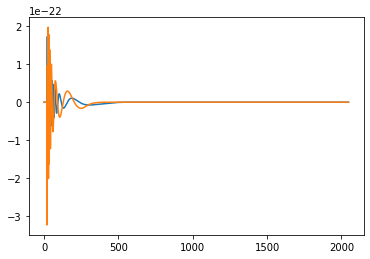

In [14]:
plt.plot(hf_template['plus'])
plt.plot(hf_signal['plus'])

In [15]:
# fs.FrequencySeries(hf_signal['plus'].reshape(1,-1), delta_f=1.)

## Logl calculation below is equivalent to bilby if we ignore detector response and psd

In [16]:
from scrinet.sample import likelihood
import tensorflow as tf

In [17]:
# def tf_log_likelihood(signal, template, delta_f = 1., psd = None):
    
#     _, qtilde_fs_sig_temp, _ = mf.matched_filter_core(signal, template, psd = psd)
    
#     d_inner_h = 4/ * np.sum(qtilde_fs_sig_temp.data)
    
#     _, qtilde_sig_sig, _ = mf.matched_filter_core(signal, signal, psd = psd)
    
#     optimal_snr_squared = 4 * np.sum(qtilde_sig_sig.data)
    
#     log_l = d_inner_h - optimal_snr_squared / 2
    
#     return log_l.real

In [18]:
# bilby.gw.utils.optimal_snr_squared??

In [19]:
# np.ones(template.data.shape[1]).shape

In [20]:
# initialise a single interferometer representing LIGO Hanford
H1 = bilby.gw.detector.get_empty_interferometer('H1')
# set the strain data at the interferometer
H1.set_strain_data_from_power_spectral_density(sampling_frequency=sampling_frequency, duration=time_duration)
# inject the gravitational wave signal into the interferometer model
# H1.inject_signal(injection_polarizations=hf_signal, parameters=injection_parameters)

/Users/Rhys/anaconda3/envs/NN_for_PE/lib/python3.8/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise


In [21]:
signal = fs.FrequencySeries(hf_signal['plus'].reshape(1,-1) , delta_f=1.)
template = fs.FrequencySeries(hf_template['plus'].reshape(1,-1) , delta_f=1.)
# psd = fs.FrequencySeries(np.ones(template.data.shape[1]).reshape(1,-1), delta_f=1.)
psd = fs.FrequencySeries(H1.power_spectral_density_array.reshape(1,-1), delta_f=1.)

In [22]:
# H1.geometry.detector_tensor??

In [23]:
H1.amplitude_spectral_density_array.shape

(2049,)

In [24]:
hf_signal['plus'].shape

(2049,)

In [25]:
likelihood._gw_log_like(signal, template, psd = psd )

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-60831.1987544])>

In [26]:
# tf_log_likelihood(signal, template, psd = None )

In [27]:
tf.math.reduce_sum

<function tensorflow.python.ops.math_ops.reduce_sum(input_tensor, axis=None, keepdims=False, name=None)>

In [28]:
tf.math.real

<function tensorflow.python.ops.math_ops.real(input, name=None)>

In [29]:
bilby_d_inner_h= bilby.gw.utils.noise_weighted_inner_product(hf_signal['plus'],
                                            hf_template['plus'],
                                            H1.power_spectral_density_array,
                                            1.)
bilby_d_inner_h

(1124.252734121002-10377.642914643764j)

In [30]:
bilby_optimal_snr_squared = bilby.gw.utils.noise_weighted_inner_product(hf_signal['plus'],
                                            hf_signal['plus'],
                                            H1.amplitude_spectral_density_array,
                                            1.)


In [31]:
bilby_d_inner_h - bilby_optimal_snr_squared/2

(1124.252734121002-10377.642914643764j)

In [32]:
bilby_log_l = np.real(bilby_d_inner_h) -bilby_optimal_snr_squared / 2
bilby_log_l.real

1124.252734121002

## Steps below implement these things in bilby

In [33]:
 bilby.gw.utils.get_polarization_tensor??

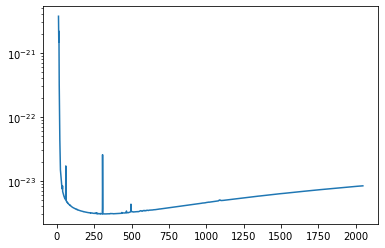

In [34]:
plt.plot(H1.amplitude_spectral_density_array)
plt.yscale('log')

In [35]:
IFOs = [H1]

In [36]:
H1.inner_product(hf_signal['plus'])

(-575.7190741329207-112.58940894716534j)

In [37]:
# compute the likelihood on each of the signal parameters
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(IFOs, waveform_generator)

In [38]:
likelihood.parameters

{}

In [39]:
new_p = injection_parameters.copy()

In [40]:
new_p.update({'mass_1':1})

In [41]:
likelihood.parameters.update(injection_parameters)

In [42]:
likelihood.parameters.update(new_p)

In [43]:
likelihood.log_likelihood_ratio()

-643.8543104127353

In [44]:
likelihood.log_likelihood()

-2687.1683573955834

In [45]:
likelihood.log_likelihood_ratio()

-643.8543104127353

In [46]:
likelihood.log_likelihood()

-2687.1683573955834

In [47]:
wvf_polarisations = waveform_generator.frequency_domain_strain()

In [48]:
from math import fmod
import lal
def bilby_get_polarization_tensor(ra, dec, time, psi, mode):
    """
    Calculate the polarization tensor for a given sky location and time

    See Nishizawa et al. (2009) arXiv:0903.0528 for definitions of the polarisation tensors.
    [u, v, w] represent the Earth-frame
    [m, n, omega] represent the wave-frame
    Note: there is a typo in the definition of the wave-frame in Nishizawa et al.
    Parameters
    -------
    ra: float
        right ascension in radians
    dec: float
        declination in radians
    time: float
        geocentric GPS time
    psi: float
        binary polarisation angle counter-clockwise about the direction of propagation
    mode: str
        polarisation mode

    Returns
    -------
    array_like: A 3x3 representation of the polarization_tensor for the specified mode.

    """
#     gmst = fmod(lal.GreenwichMeanSiderealTime(time), 2 * np.pi)
    gmst = fmod(bilby.core.utils.gps_time_to_gmst(time), 2*np.pi)
    
    theta, phi = bilby.gw.utils.ra_dec_to_theta_phi(ra, dec, gmst)
    
    u = np.array([np.cos(phi) * np.cos(theta), np.cos(theta) * np.sin(phi), -np.sin(theta)])
    v = np.array([-np.sin(phi), np.cos(phi), 0])
    
    m = -u * np.sin(psi) - v * np.cos(psi)
    n = -u * np.cos(psi) + v * np.sin(psi)

    
    if mode.lower() == 'plus':
        return np.einsum('i,j->ij', m, m) - np.einsum('i,j->ij', n, n)
    elif mode.lower() == 'cross':
        return np.einsum('i,j->ij', m, n) + np.einsum('i,j->ij', n, m)


In [49]:
# initialise a single interferometer representing LIGO Hanford
H1 = bilby.gw.detector.get_empty_interferometer('H1')
L1 = bilby.gw.detector.get_empty_interferometer('L1')

In [50]:
detector_tensors = {'H1': tf.convert_to_tensor(H1.detector_tensor,dtype = tf.float64), 
                    'L1':  tf.convert_to_tensor(L1.detector_tensor,dtype = tf.float64)}

In [51]:
def time_delay_geocentric(detector1, detector2, ra, dec, time):
    """
    Calculate time delay between two detectors in geocentric coordinates based on XLALArrivaTimeDiff in TimeDelay.c
    Parameters
    -------
    detector1: array_like
        Cartesian coordinate vector for the first detector in the geocentric frame
        generated by the Interferometer class as self.vertex.
    detector2: array_like
        Cartesian coordinate vector for the second detector in the geocentric frame.
        To get time delay from Earth center, use detector2 = np.array([0,0,0])
    ra: float
        Right ascension of the source in radians
    dec: float
        Declination of the source in radians
    time: float
        GPS time in the geocentric frame

    Returns
    -------
    float: Time delay between the two detectors in the geocentric frame

    """
    gmst = fmod(lal.GreenwichMeanSiderealTime(time), 2 * np.pi)
    theta, phi = ra_dec_to_theta_phi(ra, dec, gmst)
    omega = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
    delta_d = detector2 - detector1
    return np.dot(omega, delta_d) / speed_of_light


In [52]:
H1.time_delay_from_geocenter(1, 1, 1)

-0.015369633335574989

In [53]:
H1.geometry.vertex

array([-2161414.92636   , -3834695.17888835,  4600350.22663899])

In [54]:
H1.time_delay_from_geocenter??

In [55]:
# def do_timeshift(waveform):
#     time_shift = self.time_delay_from_geocenter(
#             parameters['ra'], parameters['dec'], parameters['geocent_time'])

#     # Be careful to first subtract the two GPS times which are ~1e9 sec.
#     # And then add the time_shift which varies at ~1e-5 sec
#     dt_geocent = parameters['geocent_time'] - self.strain_data.start_time
#     dt = dt_geocent + time_shift
  
#     # add timeshift stuff in 
#     return waveform * np.exp(-1j * 2 * np.pi * dt * frequencies)


In [56]:
def time_delay_geocentric(detector1, detector2, ra, dec, time):
    """
    Calculate time delay between two detectors in geocentric coordinates based on XLALArrivaTimeDiff in TimeDelay.c
    Parameters
    -------
    detector1: array_like
        Cartesian coordinate vector for the first detector in the geocentric frame
        generated by the Interferometer class as self.vertex.
    detector2: array_like
        Cartesian coordinate vector for the second detector in the geocentric frame.
        To get time delay from Earth center, use detector2 = np.array([0,0,0])
    ra: float
        Right ascension of the source in radians
    dec: float
        Declination of the source in radians
    time: float
        GPS time in the geocentric frame

    Returns
    -------
    float: Time delay between the two detectors in the geocentric frame

    """
    gmst = fmod(lal.GreenwichMeanSiderealTime(time), 2 * np.pi)
    theta, phi = ra_dec_to_theta_phi(ra, dec, gmst)
    omega = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
    delta_d = detector2 - detector1
    return np.dot(omega, delta_d) / speed_of_light


In [59]:
import time

In [60]:
t = time.time()

In [63]:
# ut.tf_get_antenna_response('H1', 1.,  1., t, 1., 'cross')

In [62]:
# H1.antenna_response( 1., 1., t, 1., 'cross')

0.14062548512380962

In [64]:
tf_get_antenna_response('H1', 1., 1., t, 1., 'cross')

NameError: name 'tf_get_antenna_response' is not defined

In [65]:
tf_get_antenna_response('H1', 1., 1., t, 1., 'plus')

NameError: name 'tf_get_antenna_response' is not defined

In [ ]:
tf_get_antenna_response('L1', 1., 1., t, 1., 'cross')

In [ ]:
tf_get_antenna_response('L1', 1., 1., t, 1., 'plus')

In [ ]:
import time

In [ ]:
#  bilby.gw.utils.get_polarization_tensor??

In [ ]:
t = time.time()

In [ ]:
# bilby.core.utils.gps_time_to_gmst()

In [ ]:
# tf_get_polarization_tensor(1, 1, t, 0, 'plus')
# bilby.gw.utils.get_polarization_tensor(1., 1., t, 0, 'plus')

In [ ]:
ut.tf_get_polarization_tensor(1., 1., t, 1., 'cross')

In [ ]:
bilby_get_polarization_tensor(1., 1., t, 1., 'cross')